In [10]:
import os
from PIL import Image
import torch
from transformers import  CLIPProcessor, CLIPModel
import chromadb
from datetime import datetime
from IPython.display import display, HTML
import base64


from retrieverConfig import (
    IMAGE_DIR,
    CHROMA_PERSIST_PATH,
    CHROMA_COLLECTION_NAME,
    EMBEDDING_MODEL_NAME
)

class SkinCaseRetriever:
    def __init__(self,CHROMA_PERSIST_PATH,CHROMA_COLLECTION_NAME,EMBEDDING_MODEL_NAME):
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.clip_model = CLIPModel.from_pretrained(EMBEDDING_MODEL_NAME).to(self.device)
        self.clip_processor = CLIPProcessor.from_pretrained(EMBEDDING_MODEL_NAME)
        client = chromadb.PersistentClient(path=CHROMA_PERSIST_PATH)
        self.collection = client.get_collection(name=CHROMA_COLLECTION_NAME)
    def is_description_relevant(self, text: str) -> bool:
        if not text or not text.strip(): return False
        keywords = ["痒","红","疼","痛","斑","疹","痘","水泡","脱皮","肿","硬块","皮肤","胳膊","腿","脸","背","身上","长了","起了","发现","疙瘩","变大","扩散","出血","结痂","流脓","不舒服","症状","itch","itchy","red","pain","painful","spot","rash","pimple","blister","peel","swollen","lump","skin","arm","leg","face","back","body","found","noticed","symptom","lesion","bump","grew","spread","bleed","scab","pus","sore"]
        text_lower = text.lower()
        for keyword in keywords:
            if keyword in text_lower: return True
        return False
    def retrieve_similar_cases(self, user_image_path: str, user_text: str, k: int = 3):
        # if not os.path.exists(user_image_path): raise FileNotFoundError(f"User image not found: {user_image_path}")
        # user_image = Image.open(user_image_path).convert("RGB")
        image_inputs = self.clip_processor(images=user_image, return_tensors="pt").to(self.device)
        with torch.no_grad(): query_image_embedding = self.clip_model.get_image_features(**image_inputs).cpu().numpy()
        if self.is_description_relevant(user_text):
            text_inputs = self.clip_processor(text=user_text, return_tensors="pt", padding=True, truncation=True).to(self.device)
            with torch.no_grad(): query_text_embedding = self.clip_model.get_text_features(**text_inputs).cpu().numpy()
            query_embedding = (query_image_embedding + query_text_embedding) / 2.0
            filter_metadata = {"type": "multimodal"}
            print("multimodal")
        else:
            query_embedding = query_image_embedding
            filter_metadata = {"type": "image"}
            print("image")
        results = self.collection.query(query_embeddings=query_embedding.flatten().tolist(), n_results=k, where=filter_metadata)
        return results

In [3]:
def display_image_base64(encoded_string):
    img_tag = f'<img src="data:image/jpeg;base64,{encoded_string}" style="max-width: 250px; border: 1px solid #ddd; padding: 4px; border-radius: 4px;"/>'
    display(HTML(img_tag))

In [8]:
def display_results(results: dict, image_base_dir: str):
    ids = results.get('ids', [[]])[0]
    metadatas = results.get('metadatas', [[]])[0]
    if not ids: print("No similar cases were found."); return
    for i, meta in enumerate(metadatas):
        print("-" * 20)
        print(f"  Reference Case {i+1}:")
        print(f"  Diagnosis: {meta.get('image_filename', 'N/A')}")
        print(f"  Diagnosis: {meta.get('disease', 'N/A')}")
        print(f"  Description: \"{meta.get('description', 'N/A')}\"")
        image_filename = meta.get('image_filename')
        if image_filename:
            full_image_path = os.path.join(image_base_dir, image_filename)
            if os.path.exists(full_image_path):
                with open(full_image_path, "rb") as image_file:
                    encoded_string = base64.b64encode(image_file.read()).decode('utf-8')
                display_image_base64(encoded_string)
    print("-" * 20)

image
--------------------
  Reference Case 1:
  Diagnosis: bk6_99.png
  Diagnosis: N/A
  Description: "Melanoma (Breslow thickness0. 45 mm): irregular pigmentation and irregular streaks. Inset, clinical presentation."



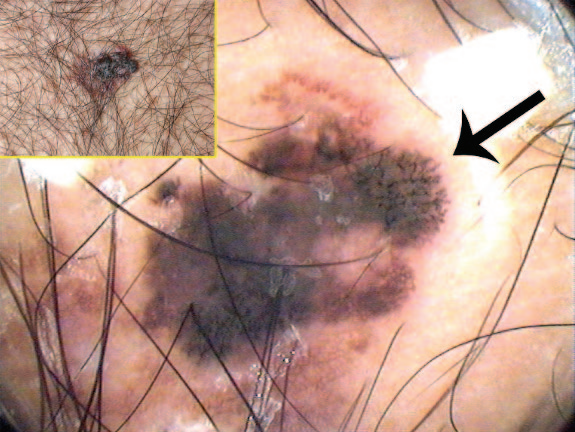

--------------------
  Reference Case 2:
  Diagnosis: bk11_695_a.png
  Diagnosis: N/A
  Description: "This lesion has a pattern that deviates from the known benign naevus patterns. It has a cobblestone globular pattern. However, at the peripheral edge there is an area with irregular dots and network. This represents a malignant melanoma developing in association with a CMN."



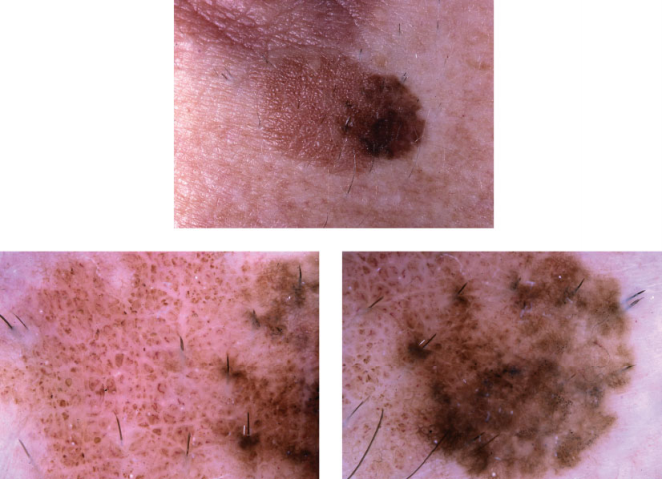

--------------------
  Reference Case 3:
  Diagnosis: bk11_695_a.png
  Diagnosis: N/A
  Description: "This lesion has a pattern that deviates from the known benign naevus patterns. It has a cobblestone globular pattern. However, at the peripheral edge there is an area with irregular dots and network. This represents a malignant melanoma developing in association with a CMN."



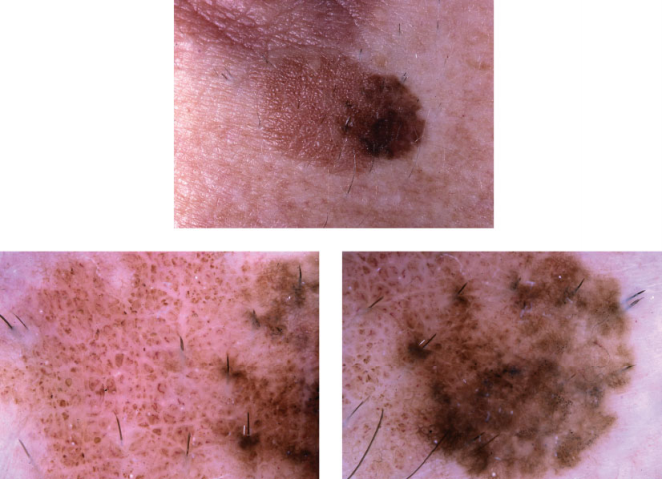

--------------------


In [19]:
retriever = SkinCaseRetriever()

user_image = Image.open(os.path.join(IMAGE_DIR,"bk15_1380.png")).convert("RGB")
retrieved_cases = retriever.retrieve_similar_cases(user_image,"describe the photo")

display_results(retrieved_cases, IMAGE_DIR)
